### loading Image

In [1]:
from PIL import Image

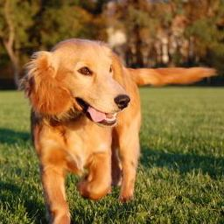

In [2]:
image = Image.open('dog.jpeg').resize((224, 224))
image

In [4]:
# load labels
with open('TF-Models-ResNet-V2-50/Labels.txt', 'r') as f:
    labels = f.read().split('\n')

### Inference by TensorFlow

In [6]:
import tensorflow as tf

In [8]:
# load models
models = tf.saved_model.load('TF-Models-ResNet-V2-50/Models')

In [13]:
%%time

# set X
x = tf.convert_to_tensor(image, dtype = tf.float32)
x = tf.expand_dims(x, axis = 0)
x = tf.divide(x, 255.0)

# get Y
y = models(x).numpy()
print("Prediction :", labels[y.argmax()].upper())

Prediction : GOLDEN RETRIEVER
CPU times: user 25.1 ms, sys: 4.08 ms, total: 29.2 ms
Wall time: 26.2 ms


### Convert .pb to .onnx

In [14]:
!python -m tf2onnx.convert \
    --saved-model TF-Models-ResNet-V2-50/Models \
    --output ONNX-Models-ResNet-V2-50/Models/model.onnx

2023-02-01 03:00:31.359409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 03:00:31.525222: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 03:00:32.358655: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/us

### Inference by ONNX

In [15]:
import onnxruntime as rt
import numpy as np

#### - on CPU

In [16]:
# load models on CPU
model_onnx_cpu = rt.InferenceSession('ONNX-Models-ResNet-V2-50/Models/model.onnx', providers = ['CPUExecutionProvider'])

In [21]:
%%time

# set X
x = np.array(image, dtype = np.float32)
x = np.expand_dims(x, axis = 0)
x = np.divide(x, 255.0)

# get Y
y = model_onnx_cpu.run(['logits'], {'inputs': x})
print("Prediction :", labels[y[0].argmax()].upper())

Prediction : GOLDEN RETRIEVER
CPU times: user 919 ms, sys: 6.31 ms, total: 925 ms
Wall time: 32.9 ms


#### - on GPU

In [22]:
# load models on GPU
model_onnx_gpu = rt.InferenceSession('ONNX-Models-ResNet-V2-50/Models/model.onnx', providers = ['CUDAExecutionProvider'])

In [27]:
%%time

# set X
x = np.array(image, dtype = np.float32)
x = np.expand_dims(x, axis = 0)
x = np.divide(x, 255.0)

# get Y
y = model_onnx_gpu.run(['logits'], {'inputs': x})
print("Prediction :", labels[y[0].argmax()].upper())

Prediction : GOLDEN RETRIEVER
CPU times: user 13.1 ms, sys: 2.99 ms, total: 16.1 ms
Wall time: 13.9 ms
